### Zahlgraf SMA 200 Strategy mit 2x SPY ETF
[Link](https://www.quantitativo.com/p/a-mean-reversion-strategy-with-211)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, cross
from backtesting.test import SMA
import matplotlib.pyplot as plt
import talib as ta

from createPerformanceChart import create_performance_chart

c:\Coding\Algotrading\backtesting.py\.venv\Lib\site-packages\backtesting\_plotting.py:53: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
# Define Performance Chart
def create_performance_chart(result, benchmark_result=None):
    # Get the equity curve and trades from the backtest result
    equity = result._equity_curve
    trades = result._trades
    
    # Create figure with two subplots (returns and drawdowns)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, 
                                 gridspec_kw={'height_ratios': [3, 1]})
    
    # 1. Plot Returns (top panel) on log scale
    strategy_returns = equity['Equity'].values
    ax1.semilogy(equity.index, strategy_returns, 'blue', label='Strategy')
    
    # If benchmark is provided, plot it too
    if benchmark_result is not None:
        benchmark_equity = benchmark_result._equity_curve
        benchmark_returns = benchmark_equity['Equity'].values
        ax1.semilogy(benchmark_equity.index, benchmark_returns, 'orange', label='Buy&Hold')
    
    ax1.set_ylabel('Total Return (log scale)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Plot Drawdowns (bottom panel)
    drawdown = equity['DrawdownPct'].values
    ax2.plot(equity.index, -drawdown, 'blue')  # Negative because backtesting.py has positive drawdown values
    
    # If benchmark is provided, plot its drawdown too
    if benchmark_result is not None:
        benchmark_drawdown = benchmark_equity['DrawdownPct'].values
        ax2.plot(benchmark_equity.index, -benchmark_drawdown, 'orange')
    
    ax2.set_ylabel('Drawdown')
    ax2.set_xlabel('Year')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.2)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

In [32]:
# Download SPY data
spy_data = yf.download('SPY', multi_level_index=False) #, start='2005-06-03')#, end='2024-05-18')
spuu_data = yf.download('SPUU', multi_level_index=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [33]:
# Ensure both datasets align by date
data = spy_data[['Open', 'High', 'Low', 'Close']].rename(columns=lambda x: f"SPY_{x}")
#spuu_data = spuu_data[['Open', 'High', 'Low', 'Close']].rename(columns=lambda x: f"SPUU_{x}")


data = data.join(spuu_data, how="inner")  # Merge SPY and SPUU on Date
data.dropna(inplace=True)

In [44]:
data

,SPY_Open,SPY_High,SPY_Low,SPY_Close,Close,High,Low,Open,Volume,SMA200
Date,,,,,,,,,,
2014-05-28,158.519028,158.767338,158.138286,158.403152,21.025028,21.119736,20.972414,21.025028,27733,NaN
2014-05-29,158.767331,159.247379,158.361758,159.222549,21.235491,21.235491,21.035553,21.109214,20133,NaN
2014-05-30,159.073536,159.578427,158.941103,159.479095,21.293367,21.303890,21.172352,21.172352,26933,NaN
2014-06-02,159.702657,159.735772,158.891525,159.661270,21.340721,21.361768,21.135522,21.361768,21467,NaN
2014-06-03,159.272192,159.661207,159.123214,159.578445,21.319674,21.319674,21.188136,21.224966,29867,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-03-07,570.900024,577.390015,565.630005,575.919983,140.449997,141.330002,135.869995,138.350006,217700,569.535448
2025-03-10,567.590027,569.539978,555.590027,560.580017,133.139999,137.589996,130.880005,136.630005,263900,569.713483
2025-03-11,559.400024,564.020020,552.020020,555.919983,130.979996,134.039993,129.149994,132.619995,154400,569.861780


In [37]:
# Compute 200-day SMA for SPY
data['SMA200'] = data['SPY_Close'].rolling(200).mean()

In [45]:
# Backtesting strategy
class SMA200CrossStrategy(Strategy):
    def init(self):
        self.spy_close = self.data.SPY_Close  # FIXED TYPO
        self.sma200 = self.I(lambda x: np.nan_to_num(pd.Series(x).rolling(200).mean()), self.spy_close)
        self.sma1 = self.I(SMA, self.spy_close, 200)
        

    def next(self):
        if crossover(self.spy_close, self.sma1):
            self.buy()  # Buy SPUU when SPY crosses above SMA200
        elif crossover(self.sma1, self.spy_close):  # Close all when SPY falls below SMA200
            self.position.close()

In [21]:
# Prepare DataFrame for backtesting (SPUU price action)
bt_data = data[['SPUU_Open', 'SPUU_High', 'SPUU_Low', 'SPUU_Close']]
bt_data.columns = ['Open', 'High', 'Low', 'Close']  # Rename for backtesting.py compatibility

In [46]:
# Run backtest
bt = Backtest(data, SMA200CrossStrategy, cash=100000, commission=0.0000,)
stats = bt.run()
print(stats)
#bt.plot()

Start                     2014-05-28 00:00:00
End                       2025-03-13 00:00:00
Duration                   3942 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                     100000.0
Equity Peak [$]                      100000.0
Return [%]                                0.0
Buy & Hold Return [%]                418.5924
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
CAGR [%]                                  0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                   

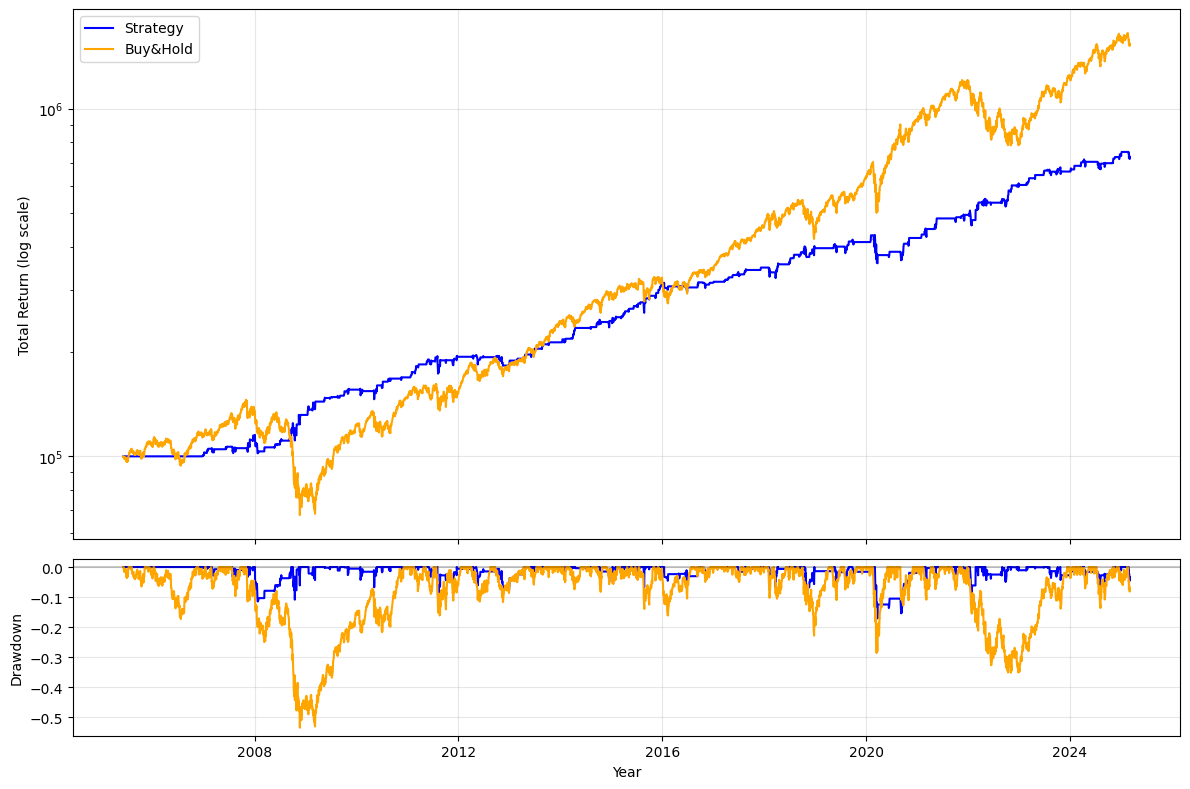

In [27]:
# Define a simple buy and hold strategy for benchmark comparison
class BuyAndHold(Strategy):
    def init(self):
        pass
    
    def next(self):
        if len(self.trades) == 0:
            self.buy()

 # Initialize and run buy & hold benchmark
bt_buyhold = Backtest(data, BuyAndHold, cash=100000, commission=.000)
buyhold_result = bt_buyhold.run()

# Create and display the chart
fig = create_performance_chart(stats, buyhold_result)  # benchmark_result is optional
plt.show()